In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

In [2]:
batch_size, max_len, in_features, num_heads = 1, 5, 3, 2
out_features = in_features*num_heads
X = np.random.randn(batch_size, max_len, out_features) # batch size, Sequence length, feature dimension 
X.shape

(1, 5, 6)

In [3]:
weights = np.random.randn(out_features, out_features*3)
weights.shape

(6, 18)

In [4]:
np.matmul(X, weights).shape

(1, 5, 18)

In [5]:
np.matmul(X, weights).reshape(batch_size, max_len, in_features, num_heads, 3).transpose(4, 0, 3, 2, 1).shape

(3, 1, 2, 3, 5)

In [6]:
k, q, v = np.matmul(X, weights).reshape(batch_size, max_len, in_features, num_heads, 3).transpose(4, 0, 3, 1, 2)
k.shape, q.shape, v.shape

((1, 2, 5, 3), (1, 2, 5, 3), (1, 2, 5, 3))

In [7]:
kq = np.matmul(k, q.transpose(0, 1, 3, 2))
kq.shape

(1, 2, 5, 5)

In [8]:
attention = softmax(kq, axis=-1)
attention.shape

(1, 2, 5, 5)

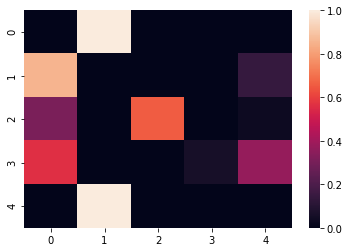

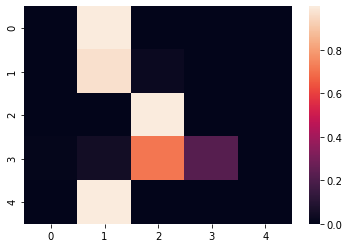

In [9]:
for row in attention:
    for att in row:
        plt.figure()
        sns.heatmap(att)

(0.0, 5.0, 5.0, 0.0)

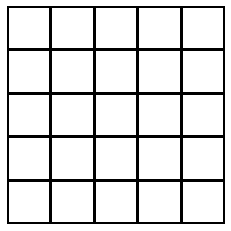

In [10]:
ax = sns.heatmap(np.zeros_like(att), cbar=False, cmap="Greys", linewidths=2, linecolor="black", square=True)
ax.axis("off")

In [11]:
z = np.matmul(v.transpose(0, 1, 3, 2), attention)
z.shape

(1, 2, 3, 5)

In [12]:
zT = z.transpose(0, 3, 2, 1)
zT.reshape(*zT.shape[:-2], -1).shape

(1, 5, 6)

In [13]:
class SelfAttention(object):
    def __init__(self, n_features, num_heads):
        assert (n_features % num_heads) == 0, f"num_heads={num_heads} should divide n_features={n_features}"
        self.num_heads = num_heads
        self.in_features = n_features // num_heads
        self.weights = np.random.randn(n_features, n_features*3)
    
    def __call__(self, X, return_attention=False):
        batch_size, max_len, _ = X.shape
        in_features = self.in_features
        num_heads = self.num_heads
        k, q, v = np.matmul(X, self.weights).reshape(
            batch_size, max_len, in_features, num_heads, 3
        ).transpose(4, 0, 3, 1, 2)
        kq = np.matmul(k, q.transpose(0, 1, 3, 2)) / np.sqrt(in_features) # Divide by sqrt(dk)
        attention = softmax(kq, axis=-1)
        z = np.matmul(v.transpose(0, 1, 3, 2), attention)
        zT = z.transpose(0, 3, 2, 1)
        zT = zT.reshape(*zT.shape[:-2], -1)
        if return_attention:
            return zT, attention
        return zT

In [14]:
self_attention_block = SelfAttention(out_features, num_heads)

In [15]:
zT = self_attention_block(X)
zT.shape

(1, 5, 6)

In [16]:
X.shape

(1, 5, 6)

In [17]:
X + zT

array([[[-0.86890532,  0.53938744, -0.55405886,  3.03202583,
         -1.6634861 ,  2.16452607],
        [-1.46519096,  3.86158888,  2.46917886,  3.33230105,
          2.25701575,  0.77132251],
        [ 0.72944962,  1.9177908 , -0.7408539 ,  1.50658511,
          0.69802523,  3.50192254],
        [ 4.20064395,  3.1862434 ,  1.31666193,  5.83716231,
         21.28334127,  2.13705837],
        [-0.35693795,  0.80508679,  0.19077483,  6.42032929,
         -3.00990047, -0.60863669]]])

In [18]:
def disp_ndarray(x: np.ndarray, ax=None, title="x", cmap="Reds", plot_values=False):
    shape = x.shape
    if len(shape) > 2:
        nrows = 1 if len(shape) < 4 else shape[-4]
        ncols = shape[-3]
        fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, squeeze=False)
        if len(shape) < 4:
            x = x[np.newaxis, :]
        for row in range(nrows):
            for col in range(ncols):
                disp_ndarray(x[row, col, :], ax=ax[row, col], title=f"{title}[{row}, {col}, :]", cmap=cmap, plot_values=plot_values)
        fig.tight_layout()
        return fig, ax
        pass
    if not plot_values:
        x = np.zeros_like(x)
        x[np.arange(x.shape[0]) % 2 == 0, :] = 1
    ax = sns.heatmap(x, cbar=False, cmap=cmap, linewidths=2, linecolor="black", square=True, ax=ax)
    ax.set_xlabel(f"$N(x[-1])$: {x.shape[1]}")
    ax.set_ylabel(f"$N(x[-2])$:  {x.shape[0]}")
    ax.set_title(title)
    #ax.axis("off")
    return ax

(<Figure size 432x288 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BBD932ECF8>]],
       dtype=object))

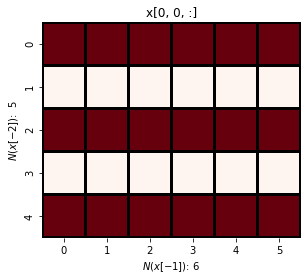

In [19]:
disp_ndarray(X)

(<Figure size 432x288 with 3 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BBD9426EF0>],
       dtype=object))

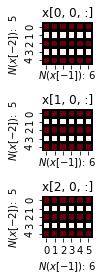

In [20]:
disp_ndarray(np.stack([X, X, X], axis=0))

(<Figure size 432x288 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BBD9169E48>,
       dtype=object))

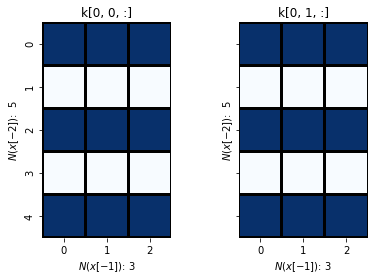

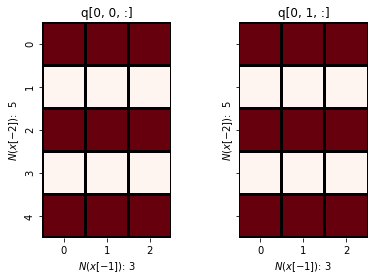

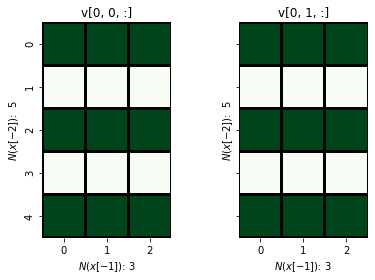

In [21]:
disp_ndarray(k, title="k", cmap="Blues")
disp_ndarray(q, title="q", cmap="Reds")
disp_ndarray(q, title="v", cmap="Greens")

In [22]:
from IPython.display import Video
from matplotlib.animation import FFMpegFileWriter

In [ ]:
with plt.style.context("dark_background"):
    fig = plt.figure(constrained_layout=True, figsize=(8,12))
    gs = fig.add_gridspec(3, 2)
    ax = fig.add_subplot(gs[:2, :2])
    ax_row = fig.add_subplot(gs[2, :])
    ax_row.set_yscale("symlog")
    ax_row.set_ylabel("Mean x along feature")
    ax_row.set_xlabel("Successive self-attention")
    moviewriter = FFMpegFileWriter(fps=1)
    cmap = "viridis"
    video_file = "with_residual.mp4"
    with moviewriter.saving(fig, video_file, dpi=200):
        #camera = Camera(fig)
        X_init = X.copy()
        row_values = []
        row_values.append(X_init[0].mean(-1))
        pallete = sns.color_palette()
        for i in range(12):
            disp_ndarray(X_init[0], plot_values=True, ax=ax, title=f"$X[{i+1}] = X[{i}] + SelfAttention(X[{i}])$", cmap=cmap);
            for j in range(row_values[-1].shape[0]):
                label=j if i == 0 else None
                ax_row.plot(np.arange(len(row_values)), [r[j] for r in row_values], color=pallete[j], label=label)
            if i == 0:
                ax_row.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="$\mathbb{E}[X[j]]$")
            zT = self_attention_block(X_init)
            X_init =  zT + X_init
            row_values.append(X_init[0].mean(-1))
            #camera.snap()
            moviewriter.grab_frame()
        disp_ndarray((X_init)[0], plot_values=True, ax=ax, title="$X = X + SelfAttention(X)$", cmap=cmap);
        for j in range(row_values[-1].shape[0]):
                ax_row.plot(np.arange(len(row_values)), [r[j] for r in row_values], color=pallete[j])
        #camera.snap()
        for j in range(5):
            moviewriter.grab_frame()
        #animation = camera.animate()
#HTML(animation.to_html5_video())
Video(video_file, width=200, height=200)

In [ ]:
with plt.style.context("dark_background"):
    fig = plt.figure(constrained_layout=True, figsize=(8,12))
    gs = fig.add_gridspec(3, 2)
    ax = fig.add_subplot(gs[:2, :2])
    ax_row = fig.add_subplot(gs[2, :])
    ax_row.set_yscale("symlog")
    ax_row.set_ylabel("Mean x along feature")
    ax_row.set_xlabel("Successive self-attention")
    moviewriter = FFMpegFileWriter(fps=1)
    cmap = "viridis"
    video_file = "without_residual.mp4"
    with moviewriter.saving(fig, video_file, dpi=200):
        #camera = Camera(fig)
        X_init = X.copy()
        row_values = []
        row_values.append(X_init[0].mean(-1))
        pallete = sns.color_palette()
        for i in range(12):
            disp_ndarray(X_init[0], plot_values=True, ax=ax, title=f"$X[{i+1}] = SelfAttention(X[{i}])$", cmap=cmap);
            for j in range(row_values[-1].shape[0]):
                label=j if i == 0 else None
                ax_row.plot(np.arange(len(row_values)), [r[j] for r in row_values], color=pallete[j], label=label)
            if i == 0:
                ax_row.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="$\mathbb{E}[X[j]]$")
            zT = self_attention_block(X_init)
            X_init =  zT 
            row_values.append(X_init[0].mean(-1))
            #camera.snap()
            moviewriter.grab_frame()
        disp_ndarray((X_init)[0], plot_values=True, ax=ax, title="$X = SelfAttention(X)$", cmap=cmap);
        for j in range(row_values[-1].shape[0]):
                ax_row.plot(np.arange(len(row_values)), [r[j] for r in row_values], color=pallete[j])
        #camera.snap()
        for j in range(5):
            moviewriter.grab_frame()
        #animation = camera.animate()
#HTML(animation.to_html5_video())
Video(video_file, width=200, height=200)

In [ ]:
with plt.style.context("dark_background"):
    fig = plt.figure(constrained_layout=True, figsize=(8,12))
    gs = fig.add_gridspec(3, 2)
    ax = fig.add_subplot(gs[:2, :2])
    ax_row = fig.add_subplot(gs[2, :])
    ax_row.set_yscale("symlog")
    ax_row.set_ylabel("Mean x along feature")
    ax_row.set_xlabel("Successive self-attention")
    moviewriter = FFMpegFileWriter(fps=1)
    cmap = "viridis"
    video_file = "with_residual_layernorm.mp4"
    with moviewriter.saving(fig, video_file, dpi=200):
        #camera = Camera(fig)
        X_init = X.copy()
        row_values = []
        row_values.append(X_init[0].mean(-1))
        pallete = sns.color_palette()
        for i in range(12):
            disp_ndarray(X_init[0], plot_values=True, ax=ax, title=f"$X[{i+1}] = SelfAttention(X[{i}])$", cmap=cmap);
            for j in range(row_values[-1].shape[0]):
                label=j if i == 0 else None
                ax_row.plot(np.arange(len(row_values)), [r[j] for r in row_values], color=pallete[j], label=label)
            if i == 0:
                ax_row.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="$\mathbb{E}[X[j]]$")
            zT = self_attention_block(X_init)
            X_init =  zT + X_init
            row_values.append(X_init[0].mean(-1))
            X_init = (X_init - X_init.mean(-1, keepdims=True))/X_init.std(-1, keepdims=True)
            #camera.snap()
            moviewriter.grab_frame()
        disp_ndarray((X_init)[0], plot_values=True, ax=ax, title="$X = SelfAttention(X)$", cmap=cmap);
        for j in range(row_values[-1].shape[0]):
                ax_row.plot(np.arange(len(row_values)), [r[j] for r in row_values], color=pallete[j])
        #camera.snap()
        for j in range(5):
            moviewriter.grab_frame()
        #animation = camera.animate()
#HTML(animation.to_html5_video())
Video(video_file, width=200, height=200)